In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

In [2]:
%matplotlib inline
import pandas as pd
import cvxportfolio as cp

In [3]:
!pip install yfinance pandas_datareader

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


Download the problem data with `yfinance`. We select five liquid stocks.

In [4]:
import yfinance
tickers = ["AMZN", "AAPL", "MSFT", "GOOGL", "TSLA"]
# start_date = "2012-01-01"
# end_date = "2016-12-31"
returns = pd.DataFrame(
    dict(
        [
            (
                ticker,
                yfinance.download(ticker)[ #, start_date=start_date, end_date=end_date)[
                    "Adj Close"
                ].pct_change(),
            )
            for ticker in tickers
        ]
    )
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
returns.describe()

,AMZN,AAPL,MSFT,GOOGL,TSLA
count,6516.000000,10668.000000,9342.000000,4690.000000,3215.000000
mean,0.001706,0.001100,0.001136,0.000991,0.002130
std,0.036090,0.028219,0.021318,0.019436,0.036154
min,-0.247661,-0.518692,-0.301158,-0.116341,-0.210628
25%,-0.013288,-0.013062,-0.009216,-0.007982,-0.015604
50%,0.000402,0.000000,0.000352,0.000755,0.001221
75%,0.014802,0.014705,0.011358,0.010082,0.019391
max,0.344714,0.332281,0.195652,0.199915,0.243951


We get the return on cash from FRED.

In [6]:
import pandas_datareader

returns[["USDOLLAR"]] =  pandas_datareader.get_data_fred("DFF", start='2000-01-01') / (250 * 100)
returns = returns.fillna(method="ffill").dropna()

returns.tail()

,AMZN,AAPL,MSFT,GOOGL,TSLA,USDOLLAR
Date,,,,,,
2023-03-31,0.012647,0.015644,0.014962,0.028150,0.062372,0.000193
2023-04-03,-0.008520,0.007702,-0.003711,0.006073,-0.061168,0.000193
2023-04-04,0.015038,-0.003250,-0.000174,0.003450,-0.011244,0.000193
2023-04-05,-0.027417,-0.011290,-0.009889,-0.002387,-0.036660,0.000193
2023-04-06,0.009496,0.005496,0.025533,0.037810,-0.002480,0.000193


We compute rolling estimates of the first and second moments of the returns using a window of 1000 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [7]:
r_hat = returns.rolling(window=1000).mean().shift(1).dropna()
Sigma_hat = returns.shift(1).rolling(window=1000).cov().dropna()

r_hat

,AMZN,AAPL,MSFT,GOOGL,TSLA,USDOLLAR
Date,,,,,,
2014-06-20,0.001314,0.001108,0.000786,0.001036,0.002961,0.000005
2014-06-23,0.001300,0.001116,0.000803,0.001059,0.002971,0.000005
2014-06-24,0.001293,0.001127,0.000804,0.001085,0.003083,0.000005
2014-06-25,0.001300,0.001127,0.000794,0.001089,0.003189,0.000005
2014-06-26,0.001302,0.001121,0.000777,0.001113,0.003368,0.000005
...,...,...,...,...,...,...
2023-03-31,0.000361,0.001441,0.001107,0.000732,0.003286,0.000048
2023-04-03,0.000376,0.001465,0.001121,0.000758,0.003376,0.000048
2023-04-04,0.000368,0.001473,0.001112,0.000753,0.003317,0.000048


In [8]:
Sigma_hat

AMZN          AAPL          MSFT         GOOGL  \
Date                                                                          
2014-06-20 AMZN      4.237160e-04  1.014461e-04  9.996405e-05  1.531471e-04   
           AAPL      1.014461e-04  2.841140e-04  7.152296e-05  1.037272e-04   
           MSFT      9.996405e-05  7.152296e-05  1.983346e-04  8.818674e-05   
           GOOGL     1.531471e-04  1.037272e-04  8.818674e-05  2.528908e-04   
           TSLA      2.003648e-04  1.220261e-04  1.074350e-04  1.364906e-04   
...                           ...           ...           ...           ...   
2023-04-06 AAPL      3.195569e-04  4.661097e-04  3.415261e-04  3.155695e-04   
           MSFT      3.274856e-04  3.415261e-04  4.113642e-04  3.398829e-04   
           GOOGL     3.208216e-04  3.155695e-04  3.398829e-04  4.366007e-04   
           TSLA      4.526107e-04  4.703272e-04  4.169271e-04  3.822836e-04   
           USDOLLAR -2.052149e-08 -1.379738e-08  3.710368e-09 -2.227037e-08   

                             TSLA      USDOLLAR  
Date                                             
2014-06-20 AMZN      2.003648e-04  9.720131e-10  
           AAPL      1.220261e-04 -6.378144e-10  
           MSFT      1.074350e-04 -7.018958e-10  
           GOOGL     1.364906e-04  2.541239e-10  
           TSLA      1.424632e-03 -6.411383e-10  
...                           ...           ...  
2023-04-06 AAPL      4.703272e-04 -1.379738e-08  
           MSFT      4.169271e-04  3.710368e-09  
           GOOGL     3.822836e-04 -2.227037e-08  
           TSLA      1.854000e-03 -1.129021e-07  
           USDOLLAR -1.129021e-07  3.227362e-09  

[13290 rows x 6 columns]

For the cash return instead we simply use the previous day's return.

In [9]:
r_hat['USDOLLAR'] = returns['USDOLLAR'].shift(1)

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [10]:
tcost_model = cp.TcostModel(half_spread=10e-4)
hcost_model = cp.HcostModel(borrow_costs=1e-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [11]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 1.0, 1.0, 1.0
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(
    return_forecast=r_hat,
    costs=[
        gamma_risk * risk_model,
        gamma_trade * tcost_model,
        gamma_hold * hcost_model,
    ],
    constraints=[leverage_limit],
)

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [12]:
market_sim = cp.MarketSimulator(
    returns, [tcost_model, hcost_model], cash_key="USDOLLAR"
)
init_portfolio = pd.Series(index=returns.columns, data=250000.0)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(
    init_portfolio,
    start_time="2020-01-01",
    end_time="2023-04-01",
    policies=[spo_policy, 
             cp.Hold()
            ],
)
results[0].summary()

Number of periods                               818
Initial timestamp               2020-01-02 00:00:00
Final timestamp                 2023-03-31 00:00:00
Portfolio return (%)                         62.376
Excess return (%)                            61.373
Excess risk (%)                              64.411
Sharpe ratio                                  0.953
Max. drawdown                                70.894
Turnover (%)                                 32.884
Average policy time (sec)                     0.026
Average simulator time (sec)                  0.002


The total value of the portfolio in time.

In [13]:
results[1].summary()

Number of periods                               818
Initial timestamp               2020-01-02 00:00:00
Final timestamp                 2023-03-31 00:00:00
Portfolio return (%)                         41.343
Excess return (%)                            40.340
Excess risk (%)                              45.013
Sharpe ratio                                  0.897
Max. drawdown                                59.516
Turnover (%)                                  0.000
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.002


<Axes: >

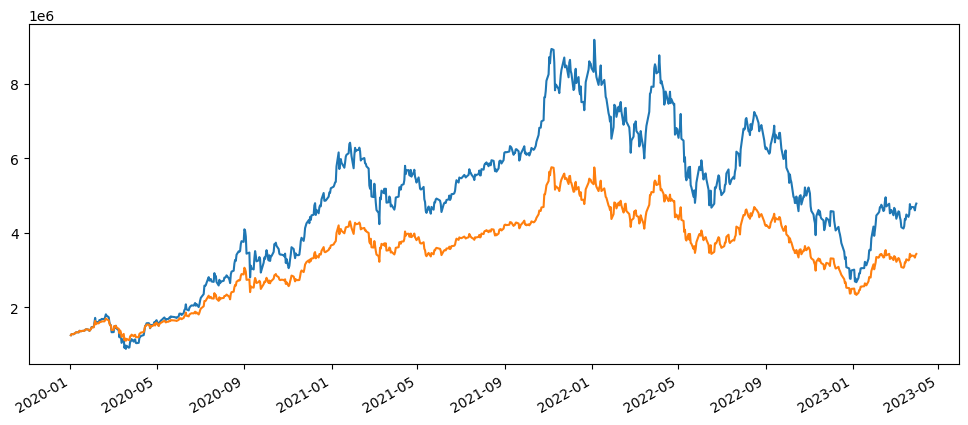

In [14]:
results[0].v.plot(figsize=(12, 5))
results[1].v.plot(figsize=(12, 5))

The weights vector of the portfolio in time.

<Axes: >

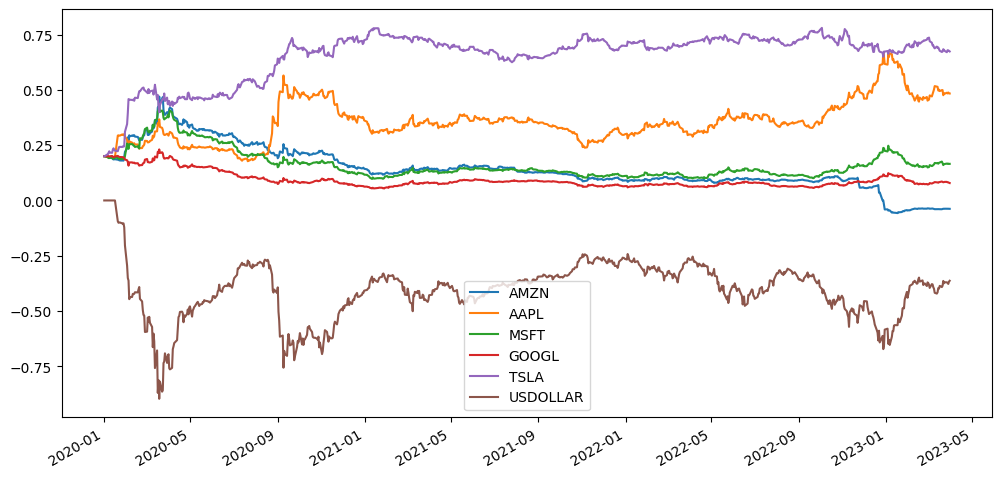

In [15]:
results[0].w.plot(figsize=(12, 6))